In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [4]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '39-efficientnetb3'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'


import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [5]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [6]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [8]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 30,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "TTA_STEPS": 5,
  "BASE_MODEL": 'EfficientNetB3',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB3',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 30,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'TTA_STEPS': 5,
 'WIDTH': 256}

# Load data

In [9]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [10]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

def data_augment_tta(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [11]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment_tta, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.00029 to 1.09e-05


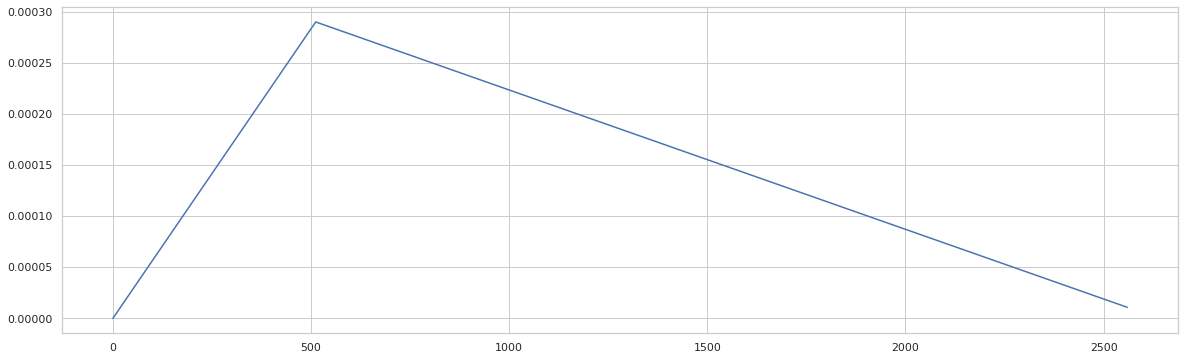

In [12]:
#@title
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB3(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [14]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        # Make predictions (last model)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)
        
        # Make predictions (best model)
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.0.227.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.227.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


43933696/43933088 [==============================] - 1s 0us/step
Epoch 1/30
93/93 - 62s - loss: 0.4592 - auc: 0.6069 - val_loss: 0.3317 - val_auc: 0.6984
Epoch 2/30
93/93 - 42s - loss: 0.2836 - auc: 0.8647 - val_loss: 0.2997 - val_auc: 0.8370
Epoch 3/30
93/93 - 43s - loss: 0.2628 - auc: 0.9000 - val_loss: 0.2727 - val_auc: 0.8829
Epoch 4/30
93/93 - 43s - loss: 0.2516 - auc: 0.9156 - val_loss: 0.2479 - val_auc: 0.9167
Epoch 5/30
93/93 - 40s - loss: 0.2411 - auc: 0.9274 - val_loss: 0.2482 - val_auc: 0.9201
Epoch 6/30
93/93 - 43s - loss: 0.2325 - auc: 0.9391 - val_loss: 0.2274 - val_auc: 0.9395
Epoch 7/30
93/93 - 43s - loss: 0.2206 - auc: 0.9504 - val_loss: 0.2238 - val_auc: 0.9388
Epoch 8/30
93/93 - 44s - loss: 0.2130 - auc: 0.9570 - val_loss: 0.2228 - val_auc: 0.9449
Epoch 9/30
93/93 - 43s - loss: 0.2053 - auc: 0.9639 - val_loss: 0.2213 - val_auc: 0.9525
Epoch 10/30
93/93 - 43s - loss: 0.1976 - auc: 0.9694 - val_loss: 0.2203 - val_auc: 0.9505
Epoch 11/30
93/93 - 43s - loss: 0.1902 - auc

INFO:tensorflow:Initializing the TPU system: grpc://10.0.227.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.227.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
93/93 - 62s - loss: 0.4680 - auc: 0.5940 - val_loss: 0.3505 - val_auc: 0.6719
Epoch 2/30
93/93 - 43s - loss: 0.2828 - auc: 0.8638 - val_loss: 0.3086 - val_auc: 0.8098
Epoch 3/30
93/93 - 43s - loss: 0.2636 - auc: 0.8969 - val_loss: 0.2688 - val_auc: 0.8993
Epoch 4/30
93/93 - 43s - loss: 0.2500 - auc: 0.9171 - val_loss: 0.2443 - val_auc: 0.9234
Epoch 5/30
93/93 - 43s - loss: 0.2395 - auc: 0.9286 - val_loss: 0.2332 - val_auc: 0.9373
Epoch 6/30
93/93 - 43s - loss: 0.2317 - auc: 0.9388 - val_loss: 0.2299 - val_auc: 0.9411
Epoch 7/30
93/93 - 43s - loss: 0.2207 - auc: 0.9492 - val_loss: 0.2228 - val_auc: 0.9524
Epoch 8/30
93/93 - 40s - loss: 0.2140 - auc: 0.9570 - val_loss: 0.2253 - val_auc: 0.9425
Epoch 9/30
93/93 - 44s - loss: 0.2057 - auc: 0.9638 - val_loss: 0.2134 - val_auc: 0.9559
Epoch 10/30
93/93 - 45s - loss: 0.1990 - auc: 0.9685 - val_loss: 0.2110 - val_auc: 0.9525
Epoch 11/30
93/93 - 43s - loss: 0.1917 - auc: 0.9716 - val_loss: 0.2073 - val_auc: 0.9617
Epoch 12/30
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.0.227.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.0.227.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/30
97/97 - 61s - loss: 0.4333 - auc: 0.6373 - val_loss: 0.3465 - val_auc: 0.6623
Epoch 2/30
97/97 - 44s - loss: 0.2783 - auc: 0.8729 - val_loss: 0.3186 - val_auc: 0.7898
Epoch 3/30
97/97 - 44s - loss: 0.2604 - auc: 0.8995 - val_loss: 0.2749 - val_auc: 0.8959
Epoch 4/30
97/97 - 45s - loss: 0.2495 - auc: 0.9180 - val_loss: 0.2556 - val_auc: 0.9242
Epoch 5/30
97/97 - 41s - loss: 0.2379 - auc: 0.9300 - val_loss: 0.2707 - val_auc: 0.9249
Epoch 6/30
97/97 - 45s - loss: 0.2290 - auc: 0.9420 - val_loss: 0.2396 - val_auc: 0.9354
Epoch 7/30
97/97 - 45s - loss: 0.2176 - auc: 0.9529 - val_loss: 0.2338 - val_auc: 0.9434
Epoch 8/30
97/97 - 45s - loss: 0.2104 - auc: 0.9588 - val_loss: 0.2259 - val_auc: 0.9470
Epoch 9/30
97/97 - 44s - loss: 0.2056 - auc: 0.9640 - val_loss: 0.2212 - val_auc: 0.9478
Epoch 10/30
97/97 - 44s - loss: 0.1960 - auc: 0.9703 - val_loss: 0.2195 - val_auc: 0.9502
Epoch 11/30
97/97 - 45s - loss: 0.1887 - auc: 0.9751 - val_loss: 0.2190 - val_auc: 0.9499
Epoch 12/30
97/97 -

## Model loss graph

Fold: 1


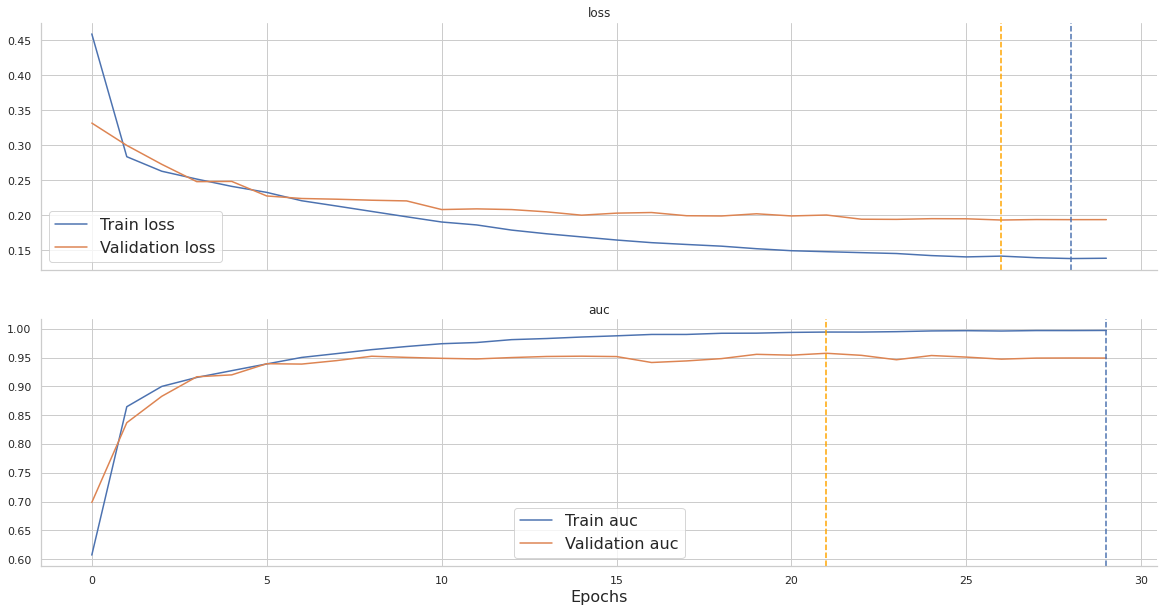

Fold: 2


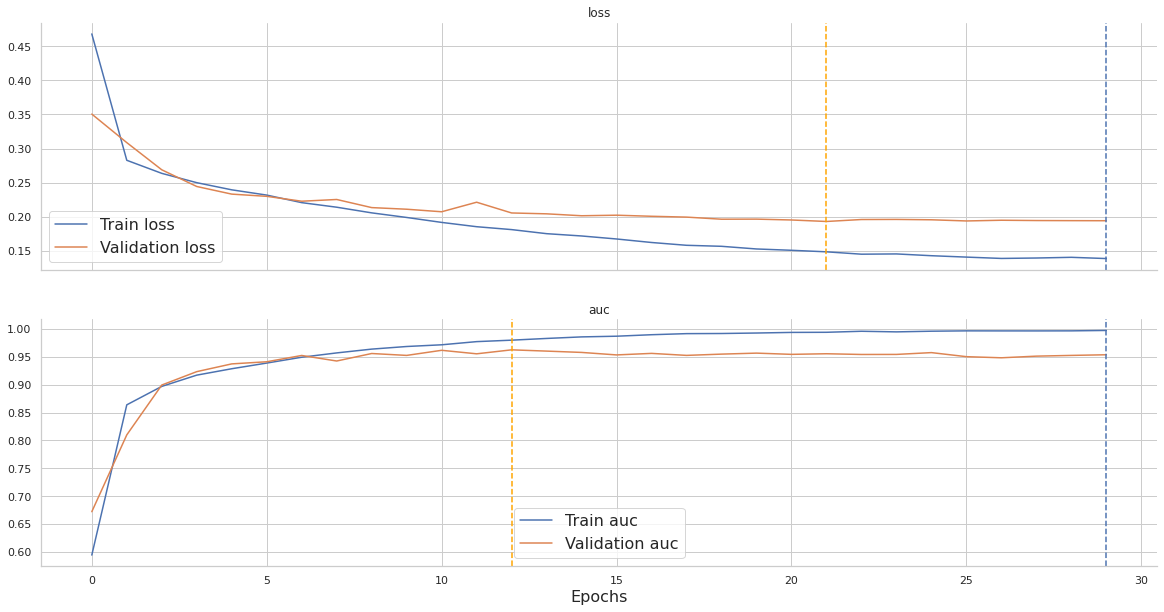

Fold: 3


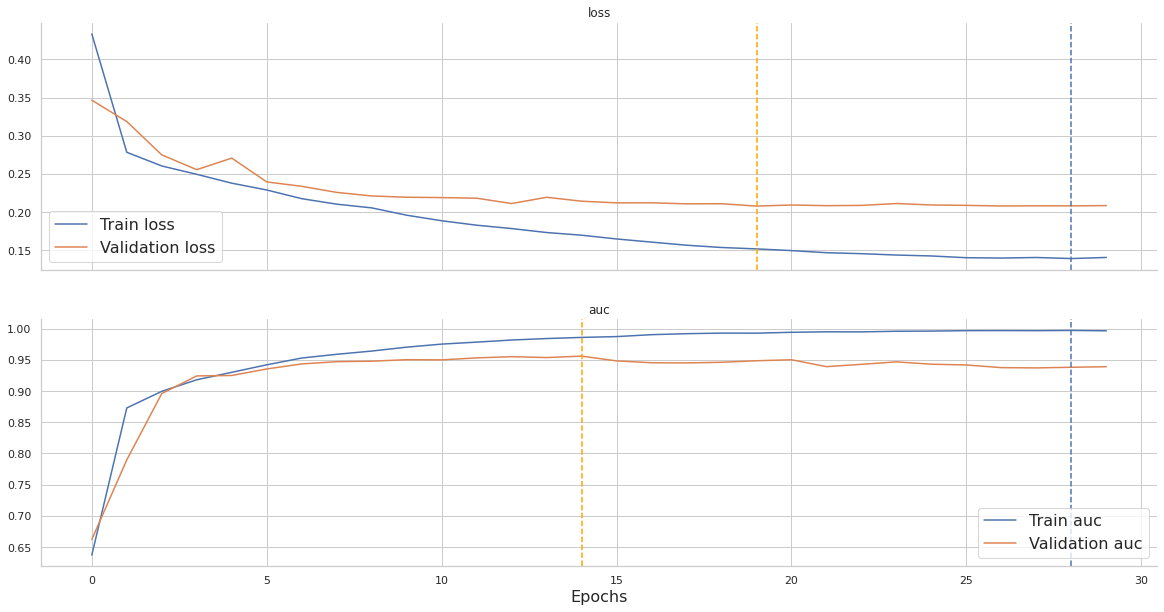

In [15]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

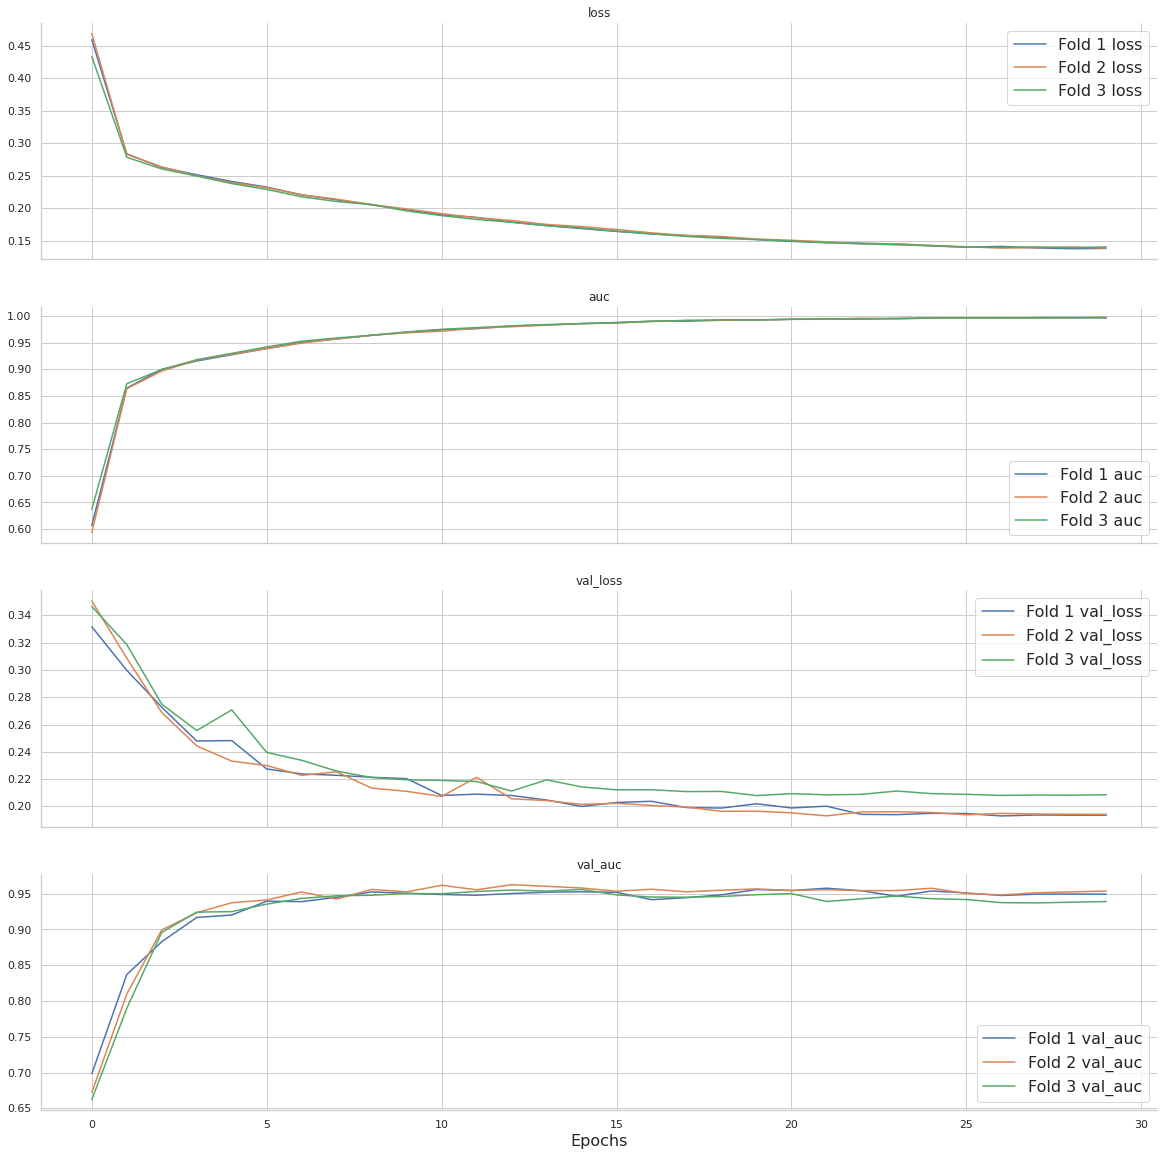

In [16]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [17]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.998466,0.810895,0.187571,0.998831,0.840309,0.998116,0.816579,0.998450,0.775796
Accuracy,0.998600,0.981299,0.017301,0.998787,0.983249,0.998519,0.981149,0.998494,0.979498
Precision,0.989388,0.453877,0.535512,0.993348,0.457143,0.986207,0.458333,0.988610,0.446154
Recall,0.930393,0.274648,0.655745,0.939203,0.299065,0.928571,0.270492,0.923404,0.254386
F1-score,0.958978,0.341937,0.617041,0.965517,0.361582,0.956522,0.340206,0.954895,0.324022
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [18]:
#@title
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.998466,0.810895,0.187571,0.998831,0.840309,0.998116,0.816579,0.998450,0.775796
male,0.999113,0.818443,0.180671,0.999024,0.832387,0.999211,0.837248,0.999105,0.785693
female,0.997435,0.794103,0.203332,0.998553,0.853459,0.996300,0.776324,0.997453,0.752525
head/neck,0.999878,0.745987,0.253891,0.999765,0.785979,0.999880,0.684372,0.999988,0.767608
upper extremity,0.999381,0.817853,0.181528,0.999393,0.824820,0.999732,0.799853,0.999018,0.828886
lower extremity,0.997549,0.752147,0.245402,0.996825,0.855373,0.997262,0.726498,0.998559,0.674569
torso,0.998132,0.859276,0.138856,0.999230,0.856533,0.997335,0.894431,0.997830,0.826863
0 <= age < 26,0.997288,0.635668,0.361619,0.996517,0.969565,0.998458,0.427254,0.996888,0.510185
26 <= age < 40,0.998832,0.768853,0.229979,0.999569,0.748304,0.999737,0.767457,0.997192,0.790800


# Model evaluation (best)

In [19]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.997282,0.839818,0.157463,0.998828,0.832610,0.996698,0.853806,0.996319,0.833039
Accuracy,0.997740,0.981386,0.016353,0.998673,0.983991,0.997190,0.979823,0.997355,0.980346
Precision,0.978077,0.462724,0.515352,0.988938,0.492537,0.957547,0.411765,0.987745,0.483871
Recall,0.891114,0.286151,0.604962,0.937107,0.308411,0.878788,0.286885,0.857447,0.263158
F1-score,0.932266,0.352795,0.579472,0.962325,0.379310,0.916479,0.338164,0.917995,0.340909
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.997282,0.839818,0.157463,0.998828,0.832610,0.996698,0.853806,0.996319,0.833039
male,0.998330,0.845774,0.152557,0.999087,0.819922,0.998492,0.868334,0.997412,0.849065
female,0.995636,0.824192,0.171444,0.998448,0.854480,0.993783,0.824528,0.994677,0.793569
head/neck,0.999054,0.796989,0.202066,0.999703,0.785012,0.999124,0.750497,0.998337,0.855457
upper extremity,0.998486,0.842468,0.156017,0.999294,0.820487,0.998733,0.834373,0.997429,0.872546
lower extremity,0.996863,0.780010,0.216853,0.996875,0.850558,0.996181,0.772174,0.997534,0.717298
torso,0.996470,0.881937,0.114533,0.999248,0.841252,0.995400,0.918241,0.994763,0.886318
0 <= age < 26,0.996479,0.738157,0.258322,0.996008,0.965761,0.997763,0.563525,0.995665,0.685185
26 <= age < 40,0.997533,0.797760,0.199773,0.999332,0.755814,0.999262,0.828594,0.994003,0.808872


# Confusion matrix

Fold: 1


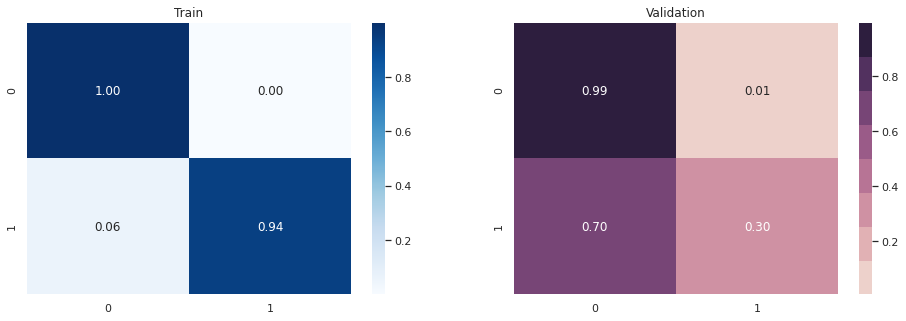

Fold: 2


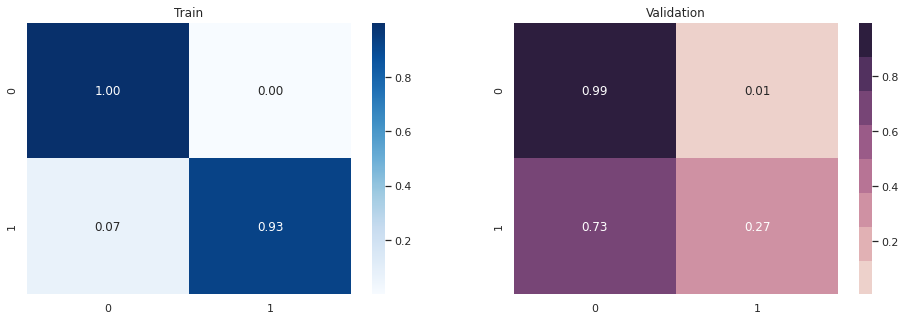

Fold: 3


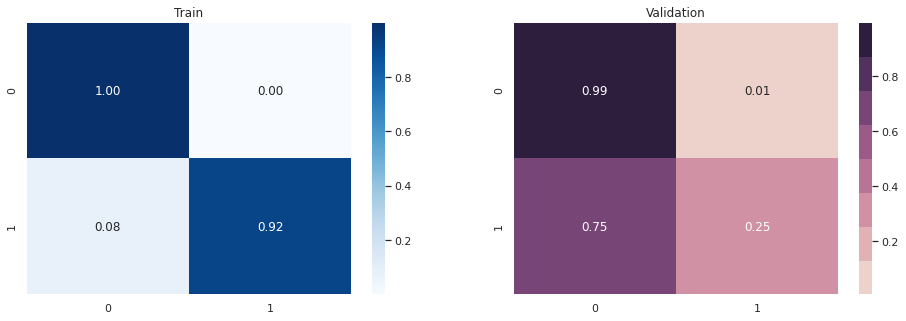

In [20]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [21]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.020003,0.035507,0.033888,0.030621
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.016467,0.023280,0.030329,0.028727
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.018357,0.030112,0.030015,0.031656
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.013518,0.025939,0.025493,0.016159
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.020220,0.037438,0.034737,0.028926
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.017139,0.031075,0.028642,0.025976
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.015728,0.021514,0.028621,0.028508
7,ISIC_0075663,female,35.0,torso,unknown,0,0.015414,0.023488,0.025676,0.027907
8,ISIC_0075914,male,30.0,torso,unknown,0,0.017654,0.027822,0.029005,0.031442
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.012703,0.016703,0.025793,0.021019


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.177985,0.055768,0.184480,0.649676
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.385062,0.933568,0.042389,0.949356
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.406144,0.985385,0.067333,0.978002
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.585070,0.945385,0.986504,0.993460
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.589757,0.987122,0.984589,0.977073
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.592493,0.978040,0.987704,0.996721
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.583297,0.969466,0.961002,0.986016
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.575249,0.914688,0.976436,0.985121
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.376509,0.076493,0.974814,0.831237
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.388245,0.961572,0.922773,0.056881


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.585070,0.945385,0.986504,0.993460
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.589757,0.987122,0.984589,0.977073
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.592493,0.978040,0.987704,0.996721
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.583297,0.969466,0.961002,0.986016
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.575249,0.914688,0.976436,0.985121
607,ISIC_0286360,male,60.0,upper extremity,melanoma,1,0.586823,0.981759,0.995609,0.956747
747,ISIC_0327406,male,40.0,upper extremity,melanoma,1,0.565934,0.975821,0.901765,0.952082
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.591094,0.981270,0.992120,0.982078
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.583084,0.969396,0.957482,0.988540
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.586591,0.984880,0.970128,0.977948


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 295
Train positive correct predictions: 295


# Make predictions (best)

In [22]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'model' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/model_fold_3.h5


In [23]:
#@title
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/model_fold_3.h5


# Make predictions (last)

In [24]:
#@title
model_path_list = glob.glob(MODEL_BASE_PATH + 'last' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/last_model_fold_3.h5


In [25]:
#@title
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset)

    # TTA preds
    for step in range(config['TTA_STEPS']):
        test_preds_tta += model.predict(test_dataset_tta)

test_preds /= n_models
test_preds_tta /= (n_models * config['TTA_STEPS'])

image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(NUM_TEST_IMAGES)))
test['target_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
# TTA
name_preds = dict(zip(image_names, test_preds_tta.reshape(NUM_TEST_IMAGES)))
test['target_tta_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/39-efficientnetb3/last_model_fold_3.h5


# Visualize test predictions

In [26]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 123|10859
Test predictions (last) 135|10847
Test predictions 120|10862
Test predictions (last) 126|10856
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.027103,0.030296,0.025248,0.026428
1,ISIC_0052349,male,40.0,lower extremity,0.027203,0.029061,0.026474,0.028793
2,ISIC_0058510,female,55.0,torso,0.025777,0.028845,0.024261,0.024732
3,ISIC_0073313,female,50.0,torso,0.036168,0.037233,0.029987,0.031267
4,ISIC_0073502,female,45.0,lower extremity,0.030730,0.030855,0.031785,0.033212
5,ISIC_0074618,male,50.0,lower extremity,0.026965,0.027177,0.026760,0.025608
6,ISIC_0076801,male,45.0,upper extremity,0.026066,0.025544,0.023388,0.025168
7,ISIC_0077586,male,50.0,lower extremity,0.030034,0.028438,0.028748,0.022093
8,ISIC_0082004,female,45.0,torso,0.024511,0.023544,0.027783,0.028626
9,ISIC_0082785,male,65.0,lower extremity,0.027894,0.027478,0.030936,0.031048


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.655929,0.658515,0.795340,0.764567
42,ISIC_0155983,male,70.0,torso,0.546124,0.671230,0.624656,0.633534
102,ISIC_0208233,female,60.0,lower extremity,0.769985,0.760521,0.891005,0.848136
109,ISIC_0216447,male,80.0,head/neck,0.632705,0.616201,0.303871,0.356435
255,ISIC_0351156,male,40.0,head/neck,0.915951,0.738832,0.753408,0.620417
296,ISIC_0391046,male,85.0,torso,0.719376,0.815663,0.727889,0.640748
403,ISIC_0481105,male,80.0,torso,0.902842,0.888750,0.881517,0.905743
471,ISIC_0539432,female,45.0,lower extremity,0.757959,0.828966,0.833714,0.790394
552,ISIC_0606244,male,70.0,torso,0.959204,0.970534,0.813824,0.866141
764,ISIC_0775584,female,35.0,lower extremity,0.510226,0.642001,0.519970,0.656660


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
24,ISIC_0112420,female,65.0,torso,0.655929,0.658515,0.795340,0.764567
42,ISIC_0155983,male,70.0,torso,0.546124,0.671230,0.624656,0.633534
102,ISIC_0208233,female,60.0,lower extremity,0.769985,0.760521,0.891005,0.848136
109,ISIC_0216447,male,80.0,head/neck,0.632705,0.616201,0.303871,0.356435
255,ISIC_0351156,male,40.0,head/neck,0.915951,0.738832,0.753408,0.620417
296,ISIC_0391046,male,85.0,torso,0.719376,0.815663,0.727889,0.640748
403,ISIC_0481105,male,80.0,torso,0.902842,0.888750,0.881517,0.905743
471,ISIC_0539432,female,45.0,lower extremity,0.757959,0.828966,0.833714,0.790394
552,ISIC_0606244,male,70.0,torso,0.959204,0.970534,0.813824,0.866141
727,ISIC_0740997,male,40.0,torso,0.394512,0.572002,0.077754,0.297164


# Test set predictions

In [27]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_tta'] = test['target_tta']
submission['target_last'] = test['target_last']
submission['target_tta_last'] = test['target_tta_last']

submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)
display(submission[['image_name', 'target']].head(10))
display(submission[['image_name', 'target']].describe())

print('TTA')
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)
display(submission_tta.head(10))
display(submission_tta.describe())

print('LAST')
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)
display(submission_last.head(10))
display(submission_last.describe())

print('TTA LAST')
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)
display(submission_tta_last.head(10))
display(submission_tta_last.describe())

,image_name,target
0,ISIC_0052060,0.027103
1,ISIC_0052349,0.027203
2,ISIC_0058510,0.025777
3,ISIC_0073313,0.036168
4,ISIC_0073502,0.030730
5,ISIC_0074618,0.026965
6,ISIC_0076801,0.026066
7,ISIC_0077586,0.030034
8,ISIC_0082004,0.024511
9,ISIC_0082785,0.027894


,target
count,10982.000000
mean,0.047598
std,0.089078
min,0.015209
25%,0.026153
50%,0.029245
75%,0.035719
max,0.993652


TTA


,image_name,target
0,ISIC_0052060,0.025248
1,ISIC_0052349,0.026474
2,ISIC_0058510,0.024261
3,ISIC_0073313,0.029987
4,ISIC_0073502,0.031785
5,ISIC_0074618,0.026760
6,ISIC_0076801,0.023388
7,ISIC_0077586,0.028748
8,ISIC_0082004,0.027783
9,ISIC_0082785,0.030936


,target
count,10982.000000
mean,0.047539
std,0.085802
min,0.017182
25%,0.026507
50%,0.029440
75%,0.035966
max,0.990804


LAST


,image_name,target
0,ISIC_0052060,0.030296
1,ISIC_0052349,0.029061
2,ISIC_0058510,0.028845
3,ISIC_0073313,0.037233
4,ISIC_0073502,0.030855
5,ISIC_0074618,0.027177
6,ISIC_0076801,0.025544
7,ISIC_0077586,0.028438
8,ISIC_0082004,0.023544
9,ISIC_0082785,0.027478


,target
count,10982.000000
mean,0.047309
std,0.092102
min,0.015314
25%,0.026433
50%,0.029100
75%,0.033842
max,0.994466


TTA LAST


,image_name,target
0,ISIC_0052060,0.026428
1,ISIC_0052349,0.028793
2,ISIC_0058510,0.024732
3,ISIC_0073313,0.031267
4,ISIC_0073502,0.033212
5,ISIC_0074618,0.025608
6,ISIC_0076801,0.025168
7,ISIC_0077586,0.022093
8,ISIC_0082004,0.028626
9,ISIC_0082785,0.031048


,target
count,10982.000000
mean,0.047872
std,0.089395
min,0.017476
25%,0.026871
50%,0.029317
75%,0.034649
max,0.993803
